In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings 
warnings.filterwarnings('ignore') 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def pre_process_features(df, isTest=False):
    window_size = 7
    short_window = 7
    long_window = 30
    ## create some features based on 'wap'
    df['wap_pctch'] = df.groupby(['stock_id','date_id'])['wap'].pct_change().values*100
    df['short_ema'] = df.groupby(['stock_id'])['wap'].ewm(span=short_window, adjust=False).mean().values
    df['long_ema'] = df.groupby(['stock_id'])['wap'].ewm(span=long_window, adjust=False).mean().values
    df['macd'] = df['short_ema'] - df['long_ema']
    ## based on seconds_in_bucket => 0, 1 feature
    df['MOC_peroid'] = df['seconds_in_bucket'].apply(lambda x:1 if x < 300  else 0)
    df['minutes'] = df['seconds_in_bucket'].apply(lambda x:x%60)
    ## date-based features
    # create week_1 to week_5 columns and fill zeros
    for k in range(5):
        df[f'week_{k+1}'] = 0
    df['week_like'] = df['date_id'].apply(lambda x: x%5 + 1)
    
    ## remove the rows which reference_price, ask_price, bid_price are missing.
    df = df.dropna(subset=['reference_price', 'bid_price', 'ask_price'])
    
    prices = ["reference_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    # other features
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    ## fill missing value at column wap_pctch by mean
    df['wap_pctch'] = df['wap_pctch'].fillna(value=df['wap_pctch'].mean())
    df = df.fillna(0)
    
    ## one-hot encoding
    week_ohe = pd.get_dummies(df['week_like'], prefix='week', dtype=int)
    
    df.drop(labels=['stock_id', 'date_id', 'seconds_in_bucket', 'matched_size', 'far_price', 'near_price', 'week_like'],axis='columns',inplace=True)
    try:
        df.drop(labels=['time_id'],axis='columns',inplace=True)
    except:
        print('')
    try:
        df.drop(labels=['row_id'],axis='columns',inplace=True)
    except:
        print('')
    try:
        df.drop(labels=['currently_scored'],axis='columns',inplace=True)
    except:
        print('')
    try:
        df.drop(labels=['target'],axis='columns',inplace=True)
    except:
        print('')

    ## check if the week column exists (for testing data)
    for k in range(5):
        if f'week_{k+1}' in week_ohe.columns:
            df[f'week_{k+1}'] = week_ohe[f'week_{k+1}']
    # let 'week_5' as base in Dummy Variables ==> so there are only week1 to week4 (week1 ~ week4 皆為0表示week5)
    df_no_norm = df.loc[:,['imbalance_buy_sell_flag', 'MOC_peroid', 'week_1', 'week_2', 'week_3', 'week_4', 'wap_pctch']] 
    df.drop(labels=['imbalance_buy_sell_flag', 'MOC_peroid', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'wap_pctch'],axis='columns',inplace=True)
    df.apply(pd.to_numeric)

    
    ## get rid of outliers
    col_names = df.columns.tolist()
    for cn in col_names:
        # use median instead of mean
        median_val = df[cn].median()
        std_dev = df[cn].std()
        # set inliers are in 3 times standard variance
        df = df[(df[cn] >= median_val - 3 * std_dev) & (df[cn] <= median_val + 3 * std_dev)]
    df = (df-df.mean())/df.std()
    df = pd.concat([df, df_no_norm], axis=1)
    if not isTest:
        df = df.dropna()
    return df

In [3]:
import lightgbm as lgb 
import xgboost as xgb 
import catboost as cbt 
import joblib 
import os 

# os.system('mkdir models')
model_path = './models'
N_fold = 2

models = []
model_dict = {
    'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=10,verbosity=0, 
    early_stopping_round=100),
    'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=10),
    'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=50),
}

def train(model_dict, i, modelname='lgb'):
    if TRAINING:
        model = model_dict[modelname]
        if modelname=='lgb':
            model.fit(X[index%N_fold!=i], Y[index%N_fold!=i], 
                        eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])])
        else:
            model.fit(X[index%N_fold!=i], Y[index%N_fold!=i], 
                        eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])],
                        early_stopping_rounds=100, verbose=None)
            
        models.append(model)
        joblib.dump(model, f'./models/{modelname}_{i}.model')
    else:
        models.append(joblib.load(f'{model_path}/{modelname}_{i}.model'))
    return 

In [4]:
'''LOADING TRAINING DATA'''
df_origin = pd.read_csv('./kaggle/input/optiver-trading-at-the-close/train.csv')
print(f'original data size: {len(df_origin)}')
df = pre_process_features(df_origin.copy())
df_target = df_origin[df_origin.index.isin(df.index)].loc[:,['target']]
print(f'processed data size: {len(df)}')

original data size: 5237980

processed data size: 4335283


In [5]:
df.isnull().sum()  

imbalance_size             0
reference_price            0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
short_ema                  0
long_ema                   0
macd                       0
minutes                    0
volume                     0
mid_price                  0
liquidity_imbalance        0
matched_imbalance          0
size_imbalance             0
imbalance_buy_sell_flag    0
MOC_peroid                 0
week_1                     0
week_2                     0
week_3                     0
week_4                     0
wap_pctch                  0
dtype: int64

In [6]:
df.head(1000)

,imbalance_size,reference_price,bid_price,bid_size,ask_price,ask_size,wap,short_ema,long_ema,macd,...,liquidity_imbalance,matched_imbalance,size_imbalance,imbalance_buy_sell_flag,MOC_peroid,week_1,week_2,week_3,week_4,wap_pctch
0,-0.080238,-0.073235,0.052940,0.595376,-0.095830,-0.643503,0.022258,0.020042,0.021778,0.004390,...,1.346855,0.466607,0.172857,1,1,1,0,0,0,0.000048
1,-0.477572,-0.031561,0.095145,-0.739194,0.221966,-0.370389,0.022258,0.006245,0.017496,-0.018850,...,-1.214068,-0.233722,-0.325872,-1,1,1,0,0,0,0.000048
2,-0.459606,-0.197764,-0.152558,0.067867,0.040512,-0.406695,0.022258,-0.010490,0.011508,-0.045540,...,0.619196,0.120897,-0.194392,-1,1,1,0,0,0,0.000048
4,-0.440535,-0.212152,-0.157080,-0.431168,-0.100842,-0.825223,0.022258,0.051508,0.028511,0.063118,...,1.682444,-0.707815,2.374664,-1,1,1,0,0,0,0.000048
5,-0.499535,0.335079,0.036360,-0.768720,0.209435,-0.707663,0.022258,0.099084,0.045284,0.139470,...,-0.791788,-0.879101,-0.312261,0,1,1,0,0,0,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,-0.312484,0.490864,0.624215,0.367474,0.475602,-0.713257,0.598333,0.037416,-0.066166,0.209859,...,1.439516,2.492461,0.335337,-1,1,1,0,0,0,0.027576
1130,-0.217776,0.153496,0.282555,-0.467255,0.198909,-0.082849,0.211432,0.048275,-0.055774,0.214893,...,-0.614503,-0.237866,-0.305110,-1,1,1,0,0,0,-0.023785
1131,-0.390489,0.242303,0.372492,-0.554693,0.250037,-0.560373,0.312056,0.034318,-0.052912,0.177803,...,-0.030288,0.956949,-0.271584,-1,1,1,0,0,0,0.020792
1132,-0.300482,0.441747,0.536790,1.209676,0.542770,0.189481,0.585754,-0.000294,-0.057728,0.108312,...,0.586983,1.488191,-0.200217,-1,1,1,0,0,0,-0.004695


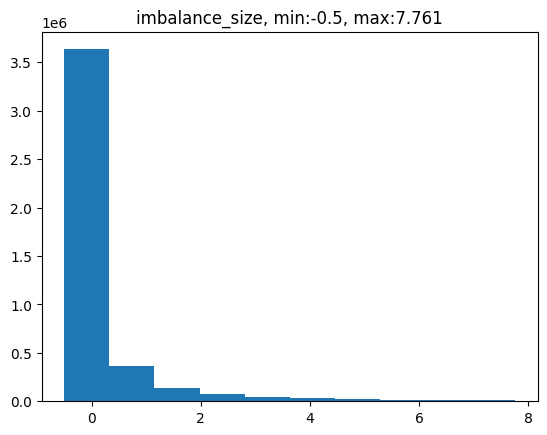

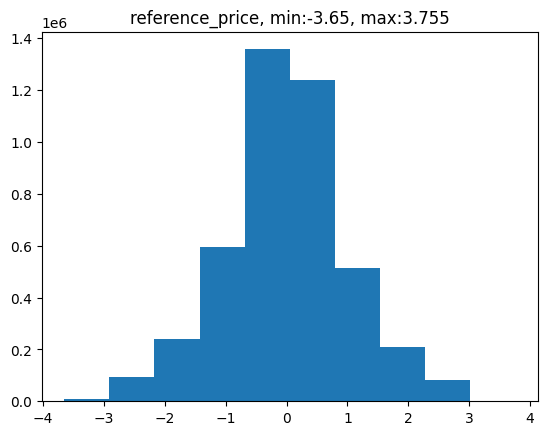

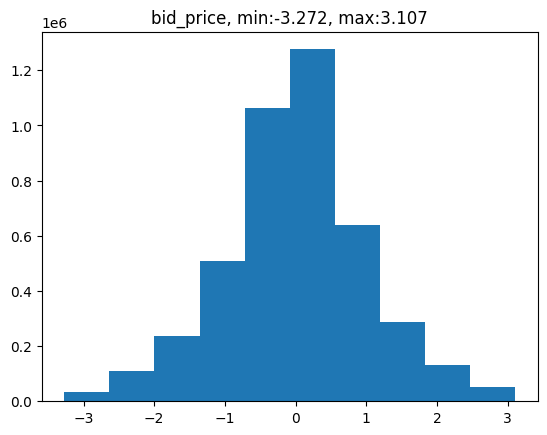

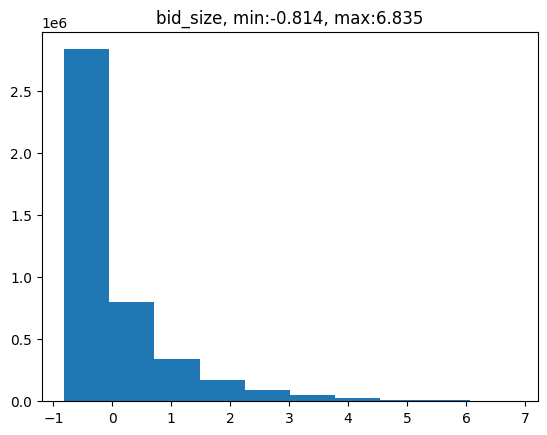

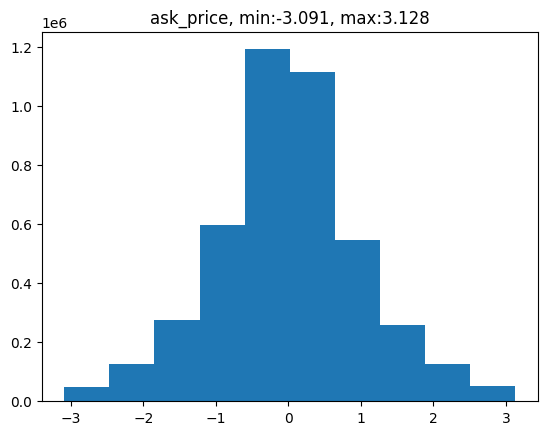

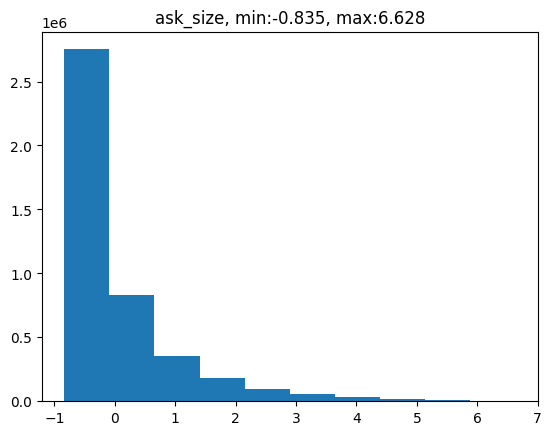

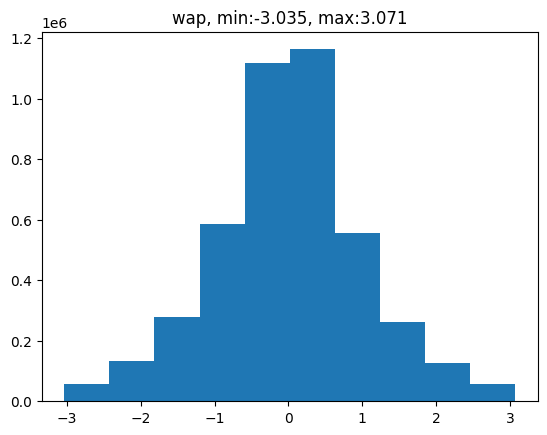

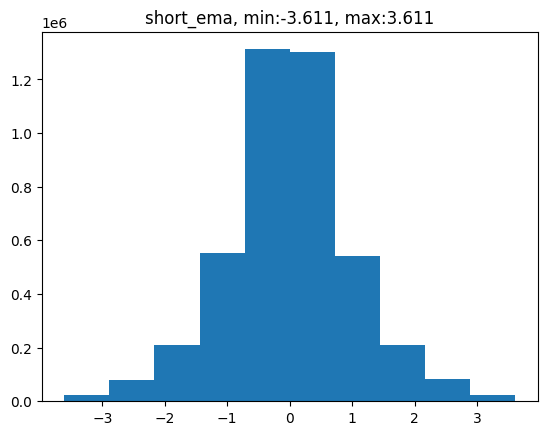

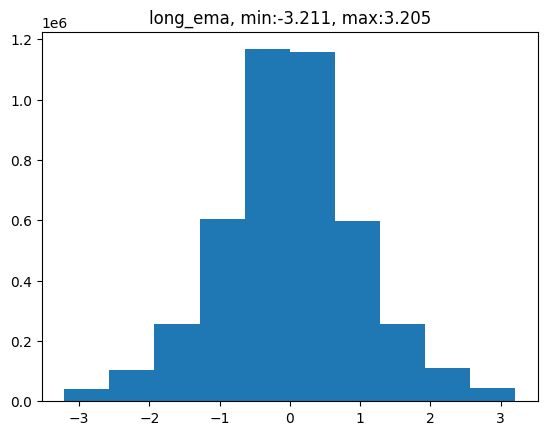

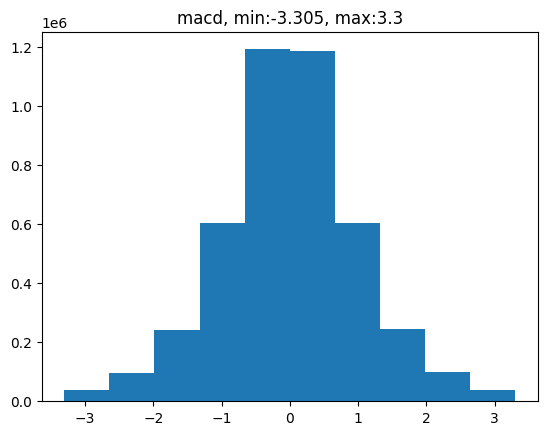

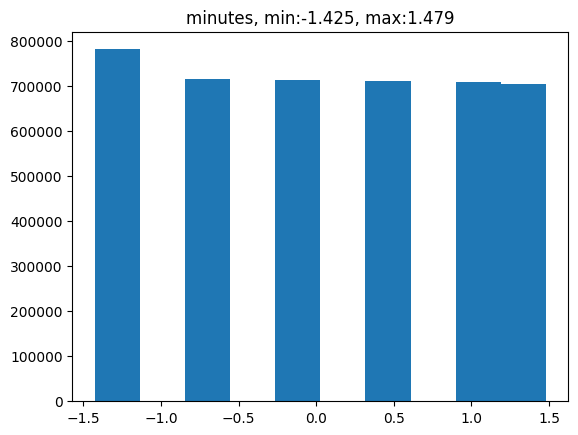

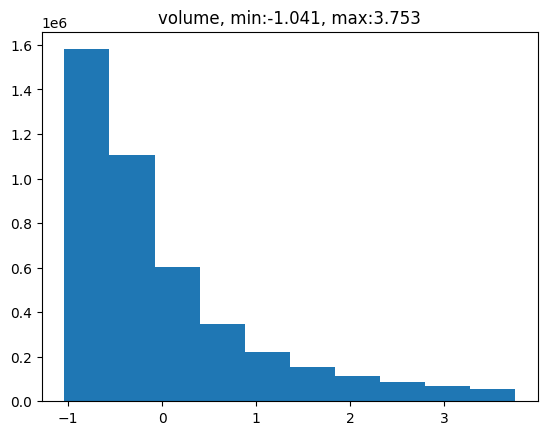

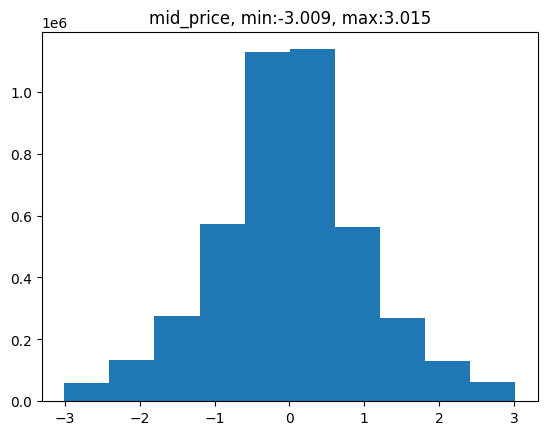

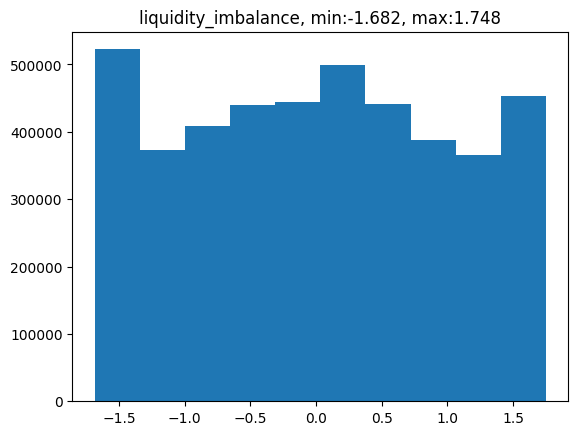

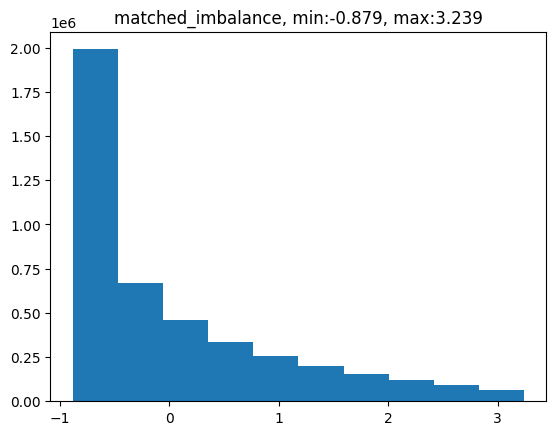

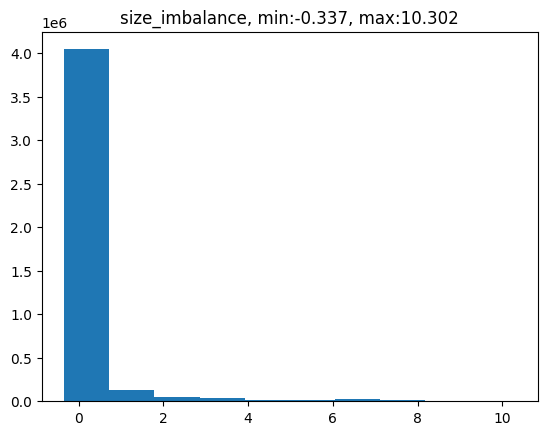

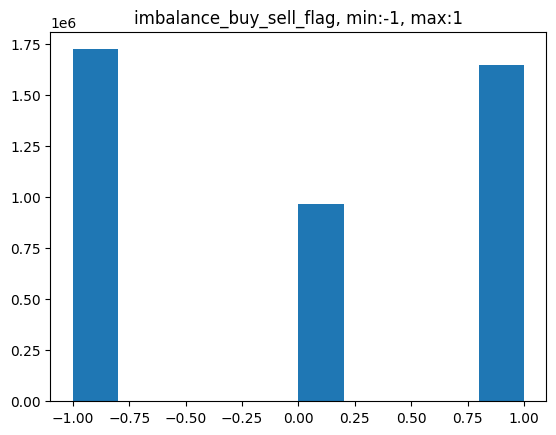

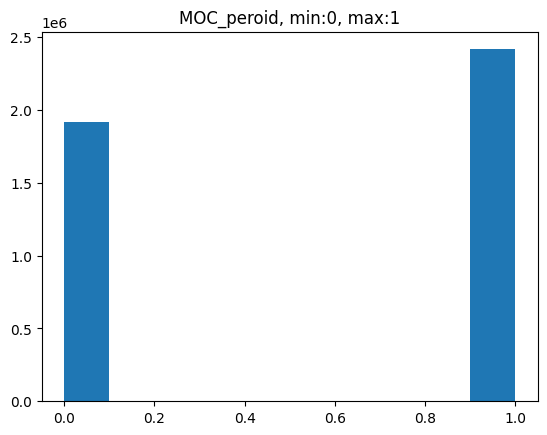

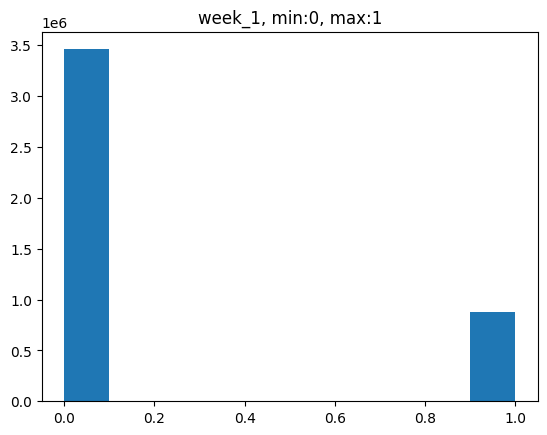

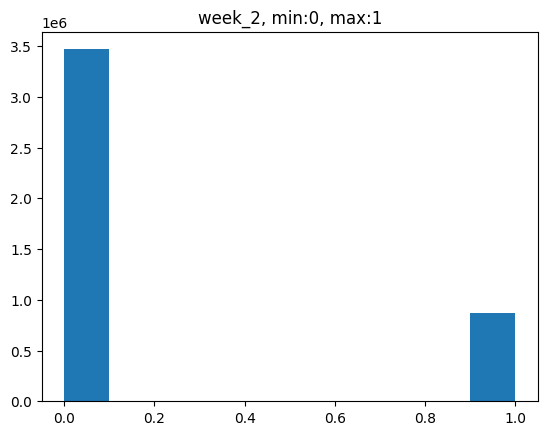

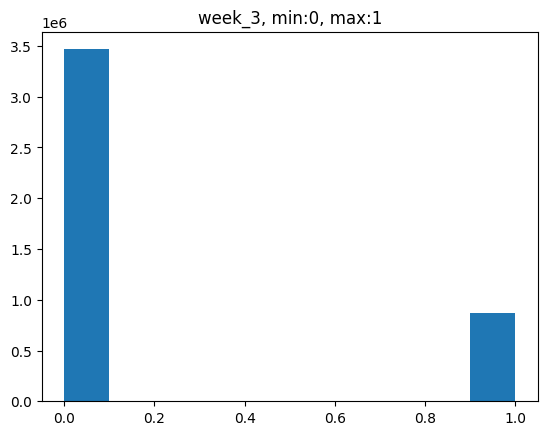

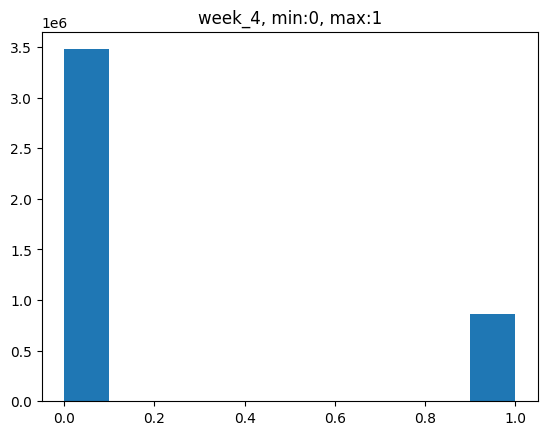

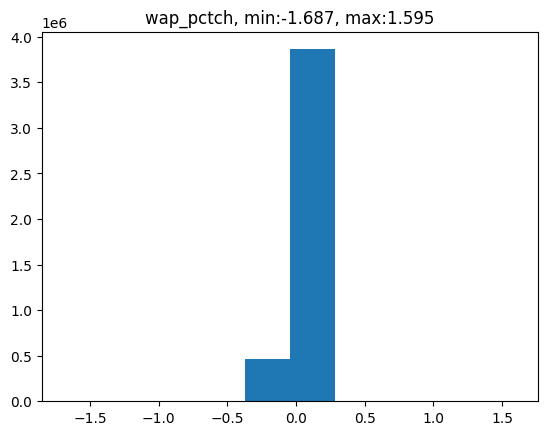

In [7]:
import matplotlib.pyplot as plt
def visualizeHists(df):
    col_names = df.columns.tolist()
    for i, cn in enumerate(col_names):
        min_, max_ = df[cn].min(), df[cn].max()
        plt.hist(df[cn], range=[min_, max_], align='mid')
        plt.title(f'{cn}, min:{round(min_, 3)}, max:{round(max_, 3)}') 
        plt.show()
visualizeHists(df)

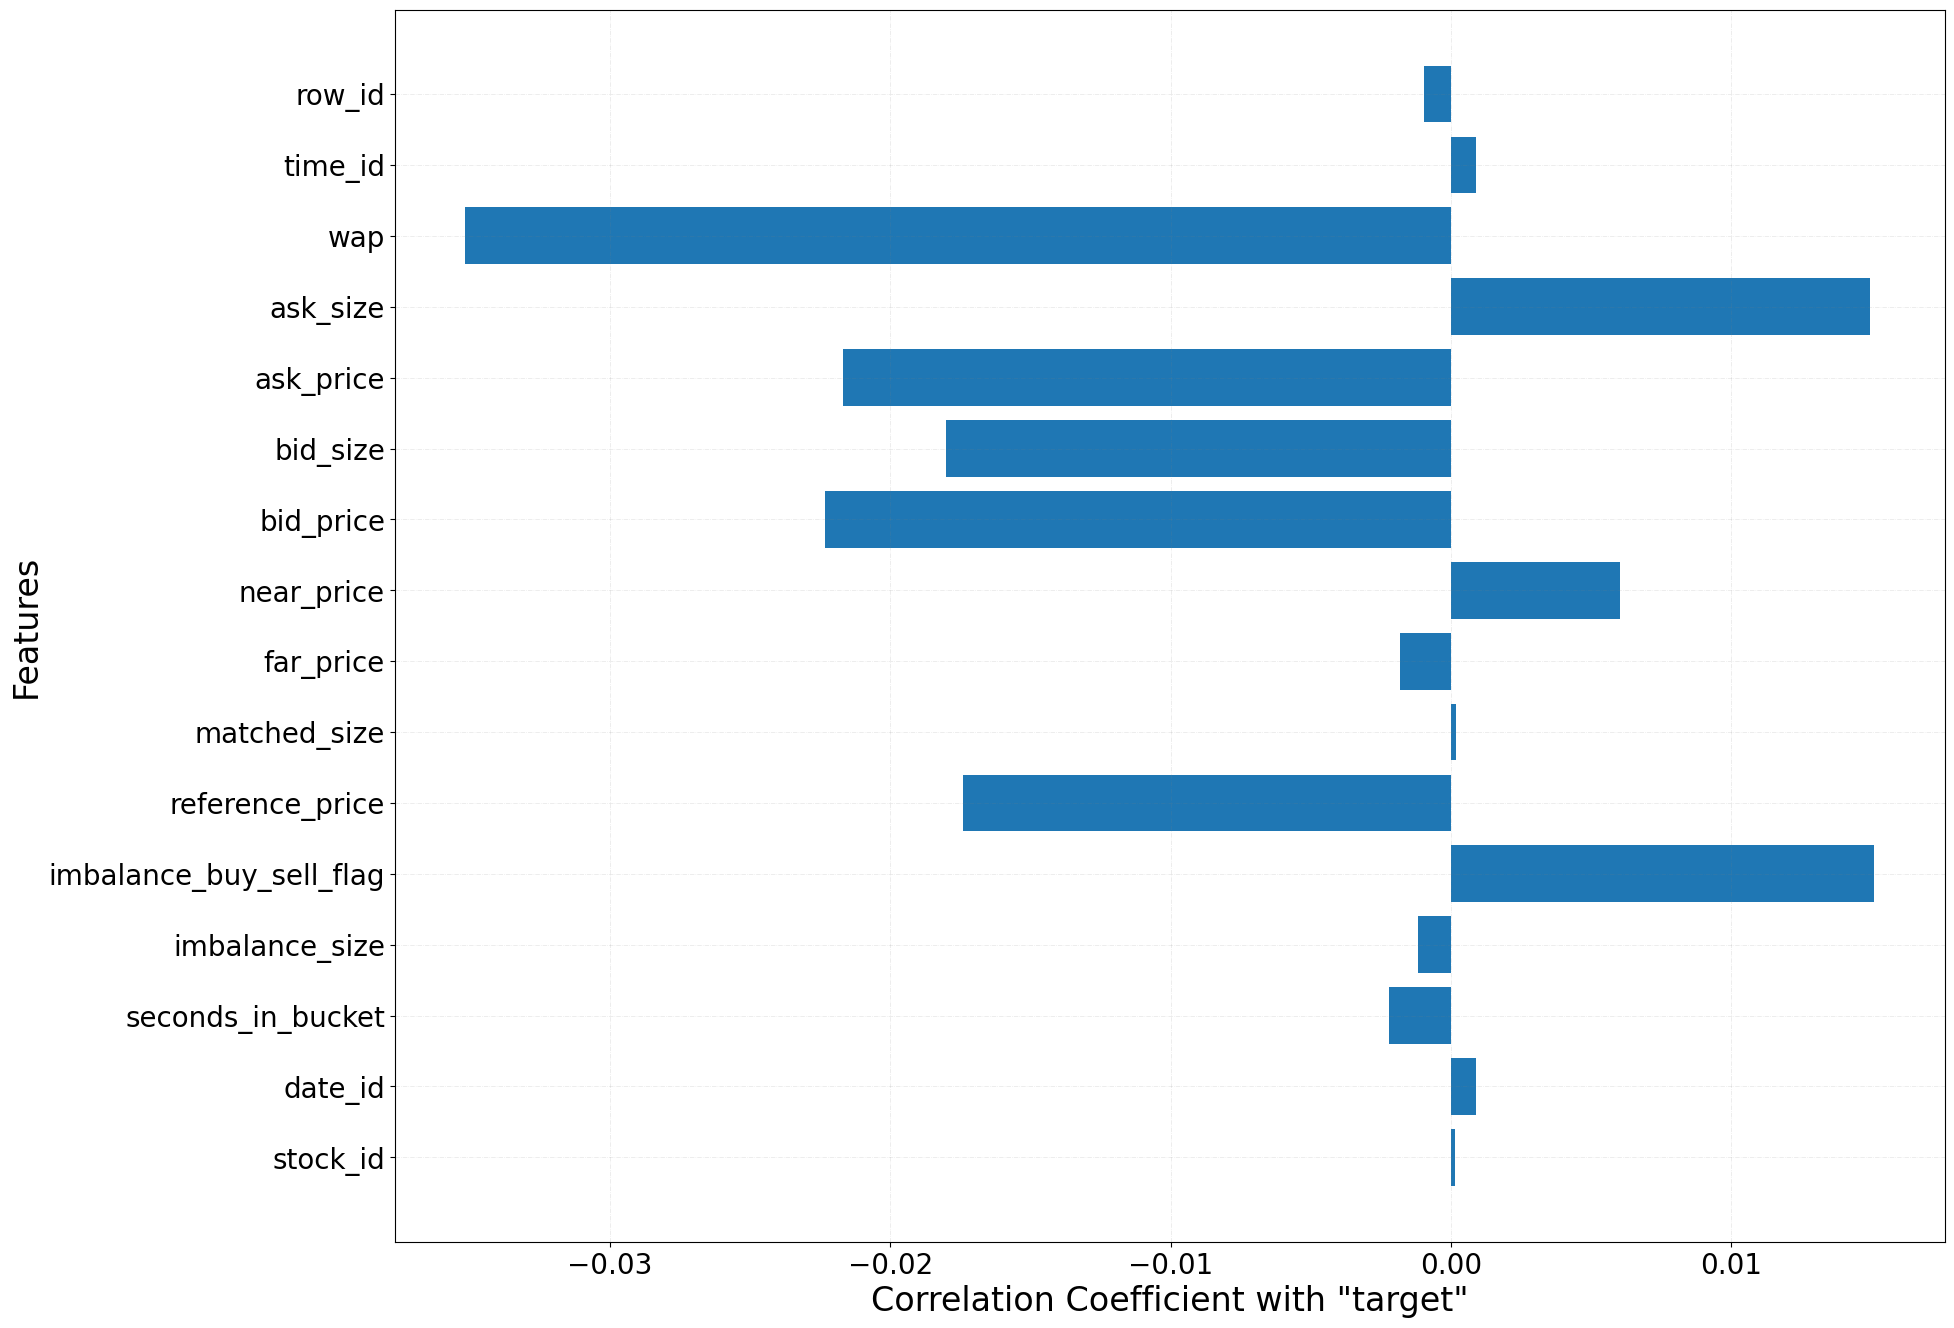

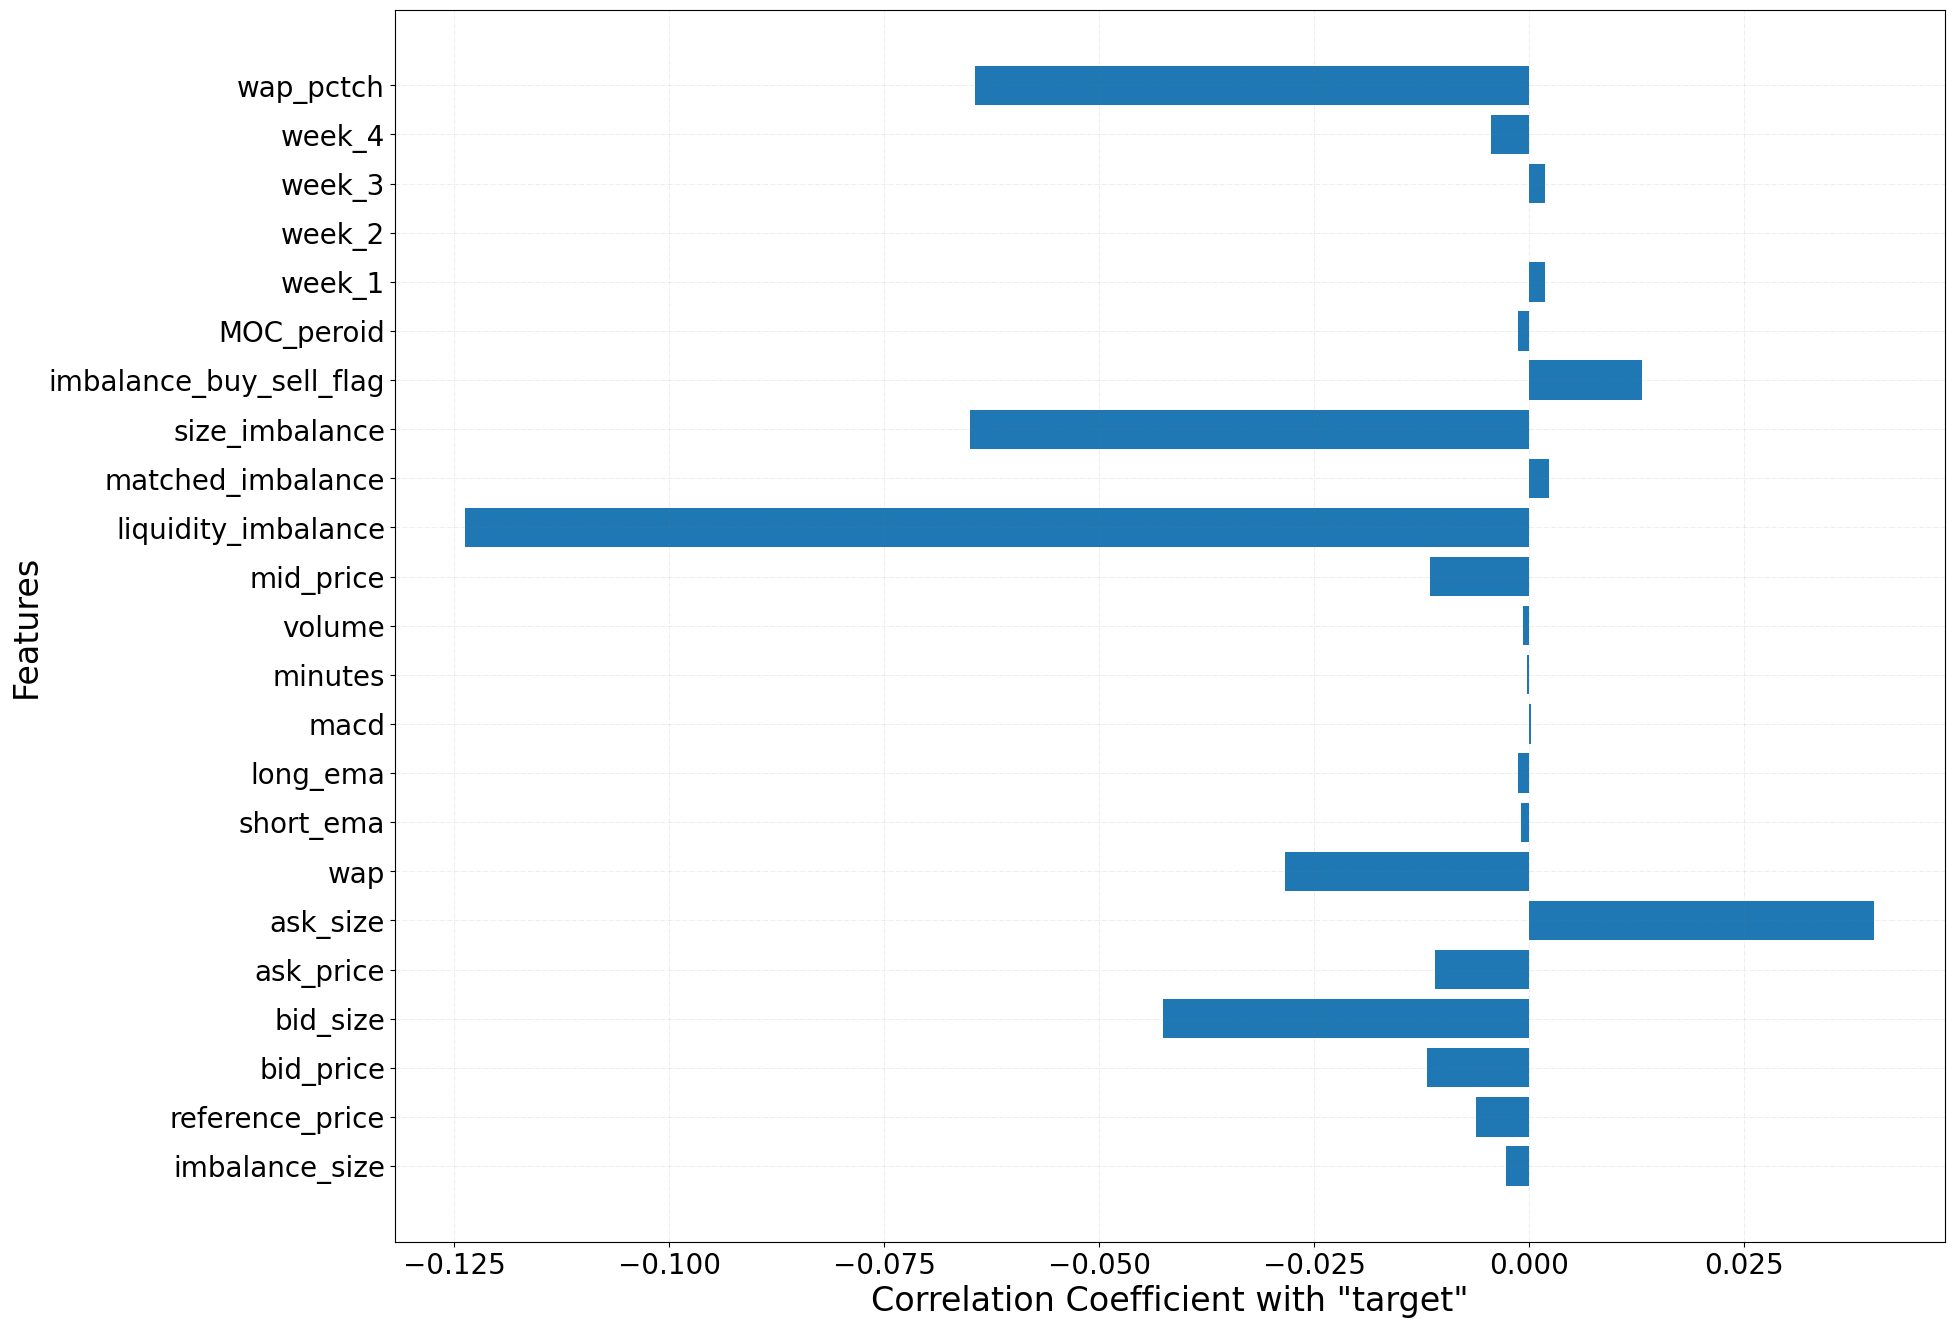

In [8]:
def plotCorrelationWithTarget(df):
    x, y = df.corr().columns.tolist(), df.corr().loc['target'].tolist()
    del y[x.index('target')]
    x.remove('target')
    fig, ax = plt.subplots(figsize=(20,16))
    ax.barh(x, y)
    ax.grid(color ='grey',linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('Correlation Coefficient with "target"', fontsize=24)
    plt.ylabel('Features', fontsize=24)
    plt.show()
    
plotCorrelationWithTarget(df_origin)
plotCorrelationWithTarget(df.join(df_target))


<Axes: >

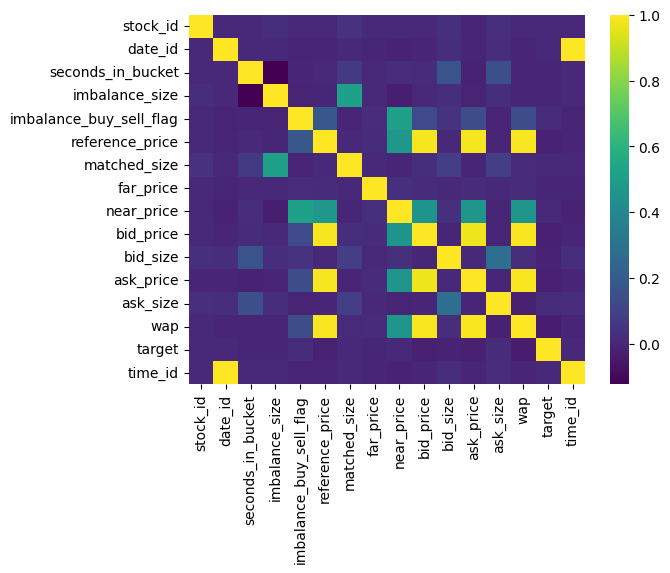

In [9]:
import seaborn as sns

''' Original Data Heatmap '''
# calculate the correlation matrix on the numeric columns
corr = df_origin.select_dtypes('number').corr()
# plot the heatmap
sns.heatmap(corr, cmap="viridis")

<Axes: >

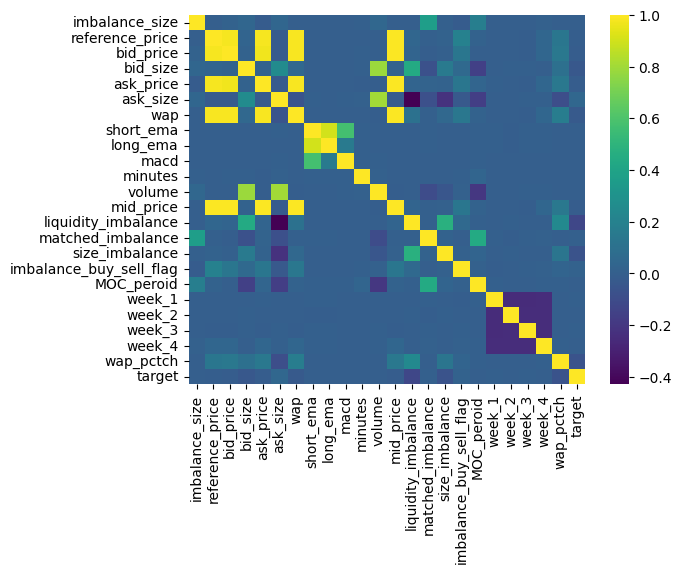

In [10]:
''' Processed Data Heatmap '''

corr = df.join(df_target).corr()
sns.heatmap(corr, cmap="viridis")

In [11]:
'''TRAINING PART'''
os.system('mkdir models')

TRAINING = True

if TRAINING:
    X = df.values
    Y = df_target['target'].values

    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))


for i in range(N_fold):
    train(model_dict, i, 'lgb')
    train(model_dict, i, 'xgb')
    train(model_dict, i, 'cbt')
    

0:	learn: 6.2106813	test: 6.2111905	best: 6.2111905 (0)	total: 375ms	remaining: 18.4s
1:	learn: 6.2076580	test: 6.2082212	best: 6.2082212 (1)	total: 624ms	remaining: 15s
2:	learn: 6.2047126	test: 6.2053227	best: 6.2053227 (2)	total: 859ms	remaining: 13.5s
3:	learn: 6.2019547	test: 6.2026127	best: 6.2026127 (3)	total: 1.09s	remaining: 12.5s
4:	learn: 6.1992455	test: 6.1999567	best: 6.1999567 (4)	total: 1.32s	remaining: 11.9s
5:	learn: 6.1967163	test: 6.1974698	best: 6.1974698 (5)	total: 1.54s	remaining: 11.3s
6:	learn: 6.1942173	test: 6.1950192	best: 6.1950192 (6)	total: 1.77s	remaining: 10.9s
7:	learn: 6.1918777	test: 6.1927140	best: 6.1927140 (7)	total: 1.99s	remaining: 10.4s
8:	learn: 6.1897602	test: 6.1906383	best: 6.1906383 (8)	total: 2.21s	remaining: 10.1s
9:	learn: 6.1875769	test: 6.1884907	best: 6.1884907 (9)	total: 2.43s	remaining: 9.72s
10:	learn: 6.1855677	test: 6.1865259	best: 6.1865259 (10)	total: 2.65s	remaining: 9.39s
11:	learn: 6.1836592	test: 6.1846638	best: 6.1846638 (

44:	learn: 6.1554875	test: 6.1541728	best: 6.1541728 (44)	total: 9.83s	remaining: 1.09s
45:	learn: 6.1550686	test: 6.1537408	best: 6.1537408 (45)	total: 10s	remaining: 872ms
46:	learn: 6.1544987	test: 6.1531737	best: 6.1531737 (46)	total: 10.2s	remaining: 653ms
47:	learn: 6.1541120	test: 6.1527814	best: 6.1527814 (47)	total: 10.4s	remaining: 435ms
48:	learn: 6.1537280	test: 6.1523864	best: 6.1523864 (48)	total: 10.7s	remaining: 218ms
49:	learn: 6.1533753	test: 6.1520241	best: 6.1520241 (49)	total: 10.9s	remaining: 0us

bestTest = 6.152024053
bestIteration = 49



In [30]:
def plotFeatImp(model_name):
    feature_importance = model_dict[model_name].feature_importances_
    feat_max = max(feature_importance)
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    # normalize importance for comparison
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx]/feat_max, align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df.columns)[sorted_idx])
    plt.title(f'{model_name}\'s Feature Importance')


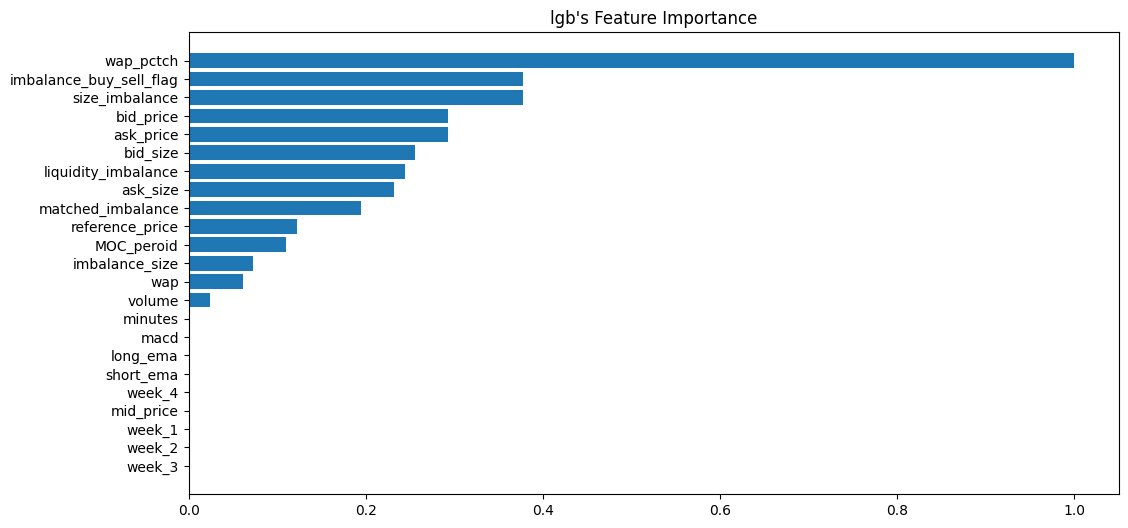

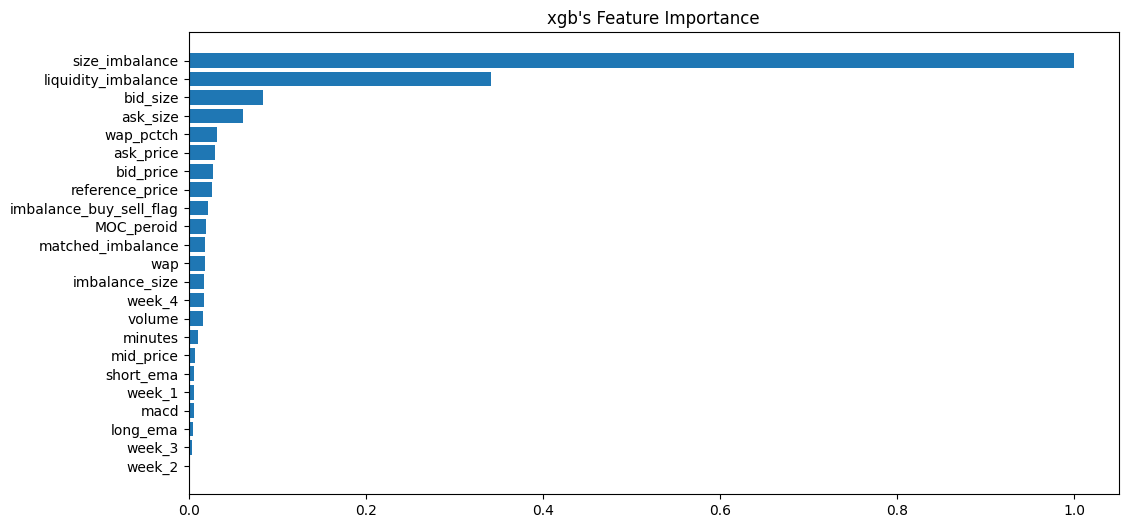

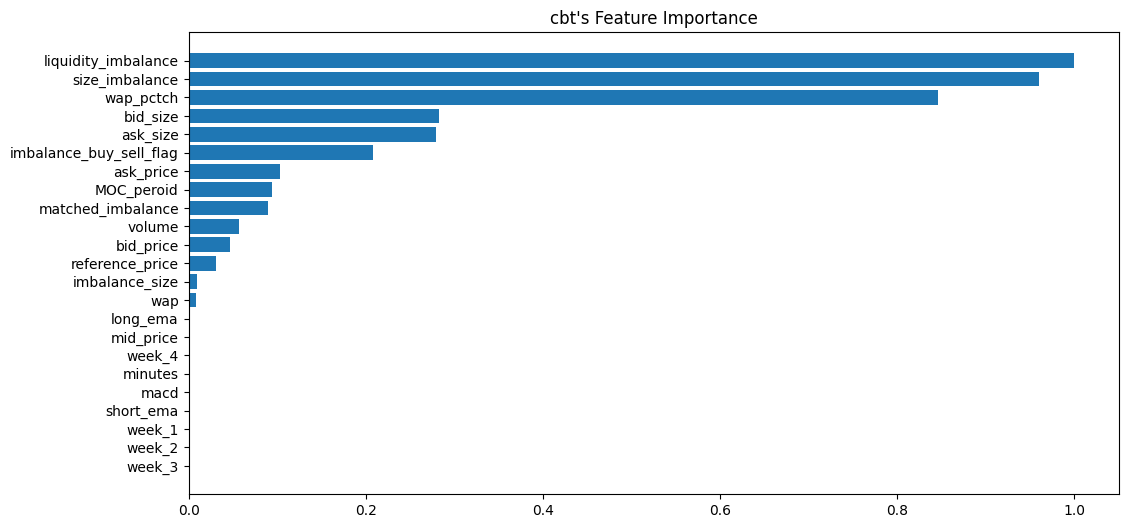

In [31]:
for model_name in ['lgb', 'xgb', 'cbt']:
    plotFeatImp(model_name)

In [9]:
'''SUBMIT'''
import optiver2023

env = optiver2023.make_env()
iter_test = env.iter_test()

if not models:
    TRAINING = False

    for i in range(N_fold):
        train(model_dict, i, 'lgb')
        train(model_dict, i, 'xgb')
        train(model_dict, i, 'cbt')

counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    feat = pre_process_features(test, True)
    
    sample_prediction['target'] = np.mean([model.predict(feat) for model in models], 0)
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.










































































































































































































































































































































